<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/solutions/palladium_dimers_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating palladium catalyst discovery: a practical application of unsupervised learning

## Table of content

1. Problem introduction
2. General clustering
3. DFT-specific descriptors
4. Final Clustering
5. Experimental validation

In this tutorial we will see how a simple algorithm like k-means can be used to discover new catalysts using few experimental data to guide the next experiments. We will see how a clever use of ML-techniques is able to reveal unintuitive patterns and suggest experiments that would be otherwise ignored.

The notebook is based on the work of Hueffel et al. and was published in this [Science](https://www.science.org/doi/full/10.1126/science.abj0999) article in 2021.

# 0. Relevant packages



Install usual packages and download the datasets.

In [ ]:
! pip install scikit-learn pandas numpy matplotlib seaborn scipy tqdm

! wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/LKB_P.csv -O ../data/LKB_P.csv
! wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/Dimer_LKB_P.csv -O ../data/Dimer_LKB_P.csv

# 1. Problem introduction

`Metal speciation` (the distribution of a metal in different physical and chemical forms) is a key property in homogeneous catalysis. This feature plays a crucial role in determining catalyst properties like reactivity or selectivity. Ligands are one of the factors related to metal speciation. Despite the common assumption that structure and reactvity are correlated, the impact of the ligand on catalytic activity is not fully understood, hampering the design of new catalysts.

<div align="left">
<img src="../img/speciation.png" width="400"/>
</div>

Palladium-catalyzed reactions are one of the most representative transformations involving homogeneous catalysts. Despite the majority of catalytic cycles involve Pd(0) and Pd(II) species, Pd(I) dimers with the [Pd(I)(&mu;-X)P(t-Bu)<sub>3</sub>]<sub>2</sub> motif are specially interesting due to their stability and catalytic performance. However, it is not fully understood why certain ligands favor Pd(I) dimers while others do not, so only few examples of this type of compounds were known.

<div align="left">
<img src="../img/pd.png" width="400"/>
</div>

The common strategy to discover new species is trial and error. Only 4 ligands promoting Pd(I) state had been discovered using this approach. Different attempts to overcome these limitations were tried. PCA decomposition using 28 general descriptors from a set of 348 monodentate phospine ligands was not able to derive ligand-speciation relationships. On the other hand, DFT calculation of the coprorportionation energy of Pd(0) with Pd(II) to Pd(I) suggested that high exergonicity was related to Pd(I) formation. However, the associated energy of PdCy<sub>3</sub> (non-inducing Pd(I) ligand) was rougly the same than the known Pd(I)-inducing phosphines, thus invalidating this hypothesis. 

<div align="left">
<img src="../img/PdDFT.png" width="400"/>
</div>

Given the few experimental points we have, *could we use unsupervised learning to leverage this knowledge and propose new candidate ligands for Pd(I) dimers discovery?*


## Exercise 1
As a first exercise, we will load the dataframe containing the 348 phosphine ligands and the general descriptors. Each molecule is also classified in one of 8 categories describing the type of ligand. The first 4 principal components of the data are also included. We will verify that PCA is unable to give good insight to the data.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ligand information
ligands = pd.read_csv('../data/LKB_P.csv', sep=';')

ligands.head()

,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(B),BE(B),P-B,DP-A(B),...,BE(Pt),P-Pt,DP-A(Pt),DA-P-A(Pt),<(H3P)Pt(PH3),S4',PC1,PC2,PC3,PC4
0,1,R,-0.24636,-0.00029,2.30,190.60,-0.590,26.10,1.941,-0.013,...,8.80,2.328,-0.001,1.5,109.4,66.9,-3.078,0.798,6.079,-1.066
1,2,R,-0.19045,0.03268,3.00,233.00,-0.680,39.20,1.926,-0.028,...,12.90,2.331,-0.010,1.3,107.5,39.4,1.602,3.976,1.536,0.090
2,3,R,-0.27742,-0.05837,3.00,182.30,-0.560,26.30,1.915,-0.002,...,22.80,2.250,0.008,-0.1,109.0,52.2,-7.226,-3.302,2.929,2.032
3,4,R,-0.26620,-0.11270,20.66,194.04,-0.538,22.51,1.924,-0.005,...,16.58,2.260,0.046,-2.4,106.6,28.7,-6.715,-9.291,1.348,-0.823
4,5,R,-0.18723,0.02584,6.00,239.10,-0.680,39.00,1.934,-0.027,...,17.10,2.338,-0.010,1.6,107.4,39.0,2.280,3.408,1.584,0.168


Now, plot the ligands using PC1 and PC2, displaying also the ligand label (from the 'Type' column). 

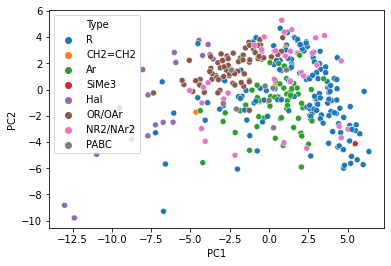

In [75]:
import seaborn as sns

sns.scatterplot(data=ligands, x='PC1', y='PC2', hue='Type');

Verify that the PCA decomposition is unable to separate Pd(I) inducing ligands from the non-inducing ligand. For this purpose, plot the dataset again and remark the datapoints that correspond to the target ligands.

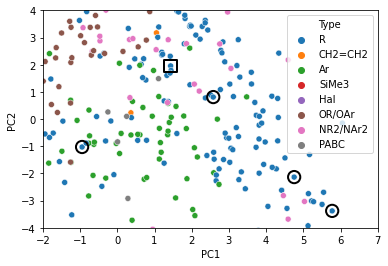

In [47]:
import seaborn as sns

#These are the indices of the positive (Pd(I) inducing) and negative ligands
pos_refs = [16, 41, 54, 113]
neg_refs = [21]

sns.scatterplot(data=ligands, x='PC1', y='PC2', hue='Type');

#Get the coordinates of positive and negative references
pos_refs_x = ligands.loc[pos_refs, 'PC1']
pos_refs_y = ligands.loc[pos_refs, 'PC2']
neg_refs_x = ligands.loc[neg_refs, 'PC1']
neg_refs_y = ligands.loc[neg_refs, 'PC2']

# plot the points in pos_refs and neg_refs with different marker style
plt.scatter(pos_refs_x, pos_refs_y, marker='o', edgecolors='black', linewidths=2, s=150, facecolors='none')
plt.scatter(neg_refs_x, neg_refs_y, marker='s', edgecolors='black', linewidths=2, s=150, facecolors='none')

plt.xlim(-2,7)
plt.ylim(-4,4)
# show the plot
plt.show()

You can clearly see how we are not able to extract clear information from PCA. Two of the Pd(I)-inducing ligands are closer to the non-inducing ligand than to the other known ligands, indicating that this analysis is not enough to suggest new species.

# 2. General property clustering

Time to change the approach! First, we will see if k-means algorithm is able to cluster our ligands efficiently. This will allow us to reduce the number of possible molecules we have to consider for experimental screening.

*Note: for the solution, we use the same code than the authors, although you don't have to create the exact same class to solve the exercise*

In [48]:
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist
from sklearn import preprocessing

def min_max_scale(X):
    """
    Scale each column in the provided pd.DataFrame to values between 0 and 1.
    :param X:   (pd.DataFrame)  The data to process.
    :return:    (pd.DataFrame)  The processed data.
    """
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    return X


def standard_scale(X):
    """
    Standardize each column in the provided pd.DataFrame.
    :param X:   (pd.DataFrame)  The data to process.
    :return:    (pd.DataFrame)  The processed data.
    """
    scaler = preprocessing.StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    return X


class KMeansModel:

    def __init__(self, X, k=8, rs=1):
        """
        Wrapper for the sklearn.KMeans algorithm that extracts relevant information.. Provides functionality to optimize
        and build the model.
        :param X:   (pd.DataFrame) The (processed) input data for the model. Needs to be provided as a pandas.DataFrame.
                                   Ideally, the index of the DataFrame refers to the identifiers within the data set.
        :param k:   (int) Cluster number to be used for the kmeans algorithm. Default: 8.
        :param rs:  (int) Random state to be used for the model. Default: 1
        """
        self.X = X
        self.k = k
        self.rs = rs

        # Storage for model
        self.model = None

        # Storage for results
        self.clusters = pd.DataFrame()

        # Storage for evaluation metrics
        self.inert = float  # Inertia
        self.dist = float  # Distortion
        self.sil = float  # Average Silhouette Score
        self.sil_sample = None  # Silhouette Score per sample

    def run(self):
        """
        Run the kmeans algorithm on the given data set with a given cluster number k and a given random state.
        """
        self.model = KMeans(n_clusters=self.k, n_init=10, init="k-means++", random_state=self.rs)
        self.model.fit(self.X)

        self.clusters = pd.DataFrame({"Cluster": self.model.labels_}, index=self.X.index)
        self.inert = float(self.model.inertia_)
        self.dist = float(sum(np.min(cdist(self.X.to_numpy(), self.model.cluster_centers_, 'euclidean'), axis=1)) /
                          self.X.shape[0])
        self.sil = float(silhouette_score(self.X.to_numpy(), self.model.labels_))
        self.sil_sample = silhouette_samples(self.X.to_numpy(), self.model.labels_)

    def opt(self, ks):
        """
        Find the optimal cluster number k from a list of different ks.
        :param ks:  (list) Values for k that should be checked during the optimization.
        :return:    metrics (pd.DataFrame): Inertia, Distortion and Average Silhouette scores for each value of k
                    clusters (pd.DataFrame): The resulting clusters for each value of k.
                    sil_samples (pd.DataFrame): Per sample silhouette score for each value of k.
        """
        metrics = pd.DataFrame(columns=["Inertia", "Distortion", "Silhouette"])
        metrics.index.name = "k"

        clusters = pd.DataFrame(index=self.X.index)
        clusters.index.name = self.X.index.name
        sil_samples = pd.DataFrame(index=self.X.index)
        sil_samples.index.name = self.X.index.name

        for k in tqdm(ks):
            self.k = k
            self.run()
            metrics.at[k, "Inertia"] = self.inert
            metrics.at[k, "Distortion"] = self.dist
            metrics.at[k, "Silhouette"] = self.sil

            clusters[f"k={k}"] = self.clusters.to_numpy().flatten()
            sil_samples[f"k={k}"] = self.sil_sample

        return metrics, clusters, sil_samples

    def stats(self, ref_ids, k=None, rs_range=None):
        """
        Investigate the dependency of the resulting clusters on different random_states. The function runs the k-means
        algorithm for each provided random state and checks how often each instance is grouped with the provided
        reference instances and calculates a normalized score.
        :param ref_ids:     (list) List of indices of the references, for which the similarity to other instances in the
                            data should be evaluated. The indices must correspond to the index in self.X!
        :param k:           (int) Cluster number k. Default: None (= use the value stored in self.k)
        :param rs_range:    (list) List of random states that should be checked. Default: None (= use range(0, 1000))
        :return:    stats (pd.DataFrame)    Table containing information on whether an instance was grouped with the
                                            references or not when using the provided random states (One-Hot-Encoded).
                                            The last column ("Score") contains the percentage of times the instance was
                                            grouped with the references.
        """
        # Range of random states to check
        rs_range = range(0, 1000) if rs_range is None else rs_range

        # Set the value for k, if provided
        self.k = k if k is not None else self.k

        # Storage
        stats = pd.DataFrame(index=self.X.index)

        # For each random state ...
        for rs in tqdm(rs_range):
            # Define a column name
            col = f"RS{rs}"
            # Run the model
            self.rs = rs
            self.run()
            # Report the resulting clusters
            stats[col] = self.clusters.to_numpy().flatten()
            # Get the clusters that contain references
            ref_cluster = list(set(stats.loc[stats.index.isin(ref_ids)][col]))
            # Get all members within these clusters
            ref_cluster_members = list(stats.loc[stats[col].isin(ref_cluster)].index)
            # One Hot Encode the results (1: instance was clustered with refs, 0: instance was not clustered with refs)
            for idx in stats.index:
                stats.at[idx, col] = 1 if idx in ref_cluster_members else 0

        # Get the total number of times a ligand was clustered with the references
        stats["Sum"] = stats.sum(axis=1)
        # Calculate percentage (= Score)
        stats["Score"] = stats["Sum"] / len(rs_range)

        return stats





Cluster optimization

In [49]:
# Load data and standardize it
process = ['E(HOMO)', 'E(LUMO)', 'He8_steric', 'PA', 'Q(B)', 'BE(B)', 'P-B', 'DP-A(B)', 'DA-P-A(B)', 'Q(Au)', 'BE(Au)',
           'Au-Cl', 'Au-P', 'DP-A(Au)', 'DA-P-A(Au)', 'Q(Pd)', 'BE(Pd)', 'Pd-Cl trans', 'P-Pd', 'DP-A(Pd)',
           'DA-P-A(Pd)', 'Q(Pt)', 'BE(Pt)', 'P-Pt', 'DP-A(Pt)', 'DA-P-A(Pt)', '<(H3P)Pt(PH3)', "S4'"]
# Columns in the data set to exclude from clustering
drop = ['Type', "PC1", "PC2", "PC3", "PC4"]


# Data preprocessing
X = standard_scale(ligands.drop(columns=drop))

#Initialize model
model = KMeansModel(X=X, k=8, rs=1)

# Run the optimization and get metrics, clusters and per sample silhouette scores for each value of k
metrics, clusters, sil_samples = model.opt(ks=range(2, 15))

100%|██████████| 13/13 [00:01<00:00, 12.82it/s]


Plot metrics to select the best k based on this analysis.

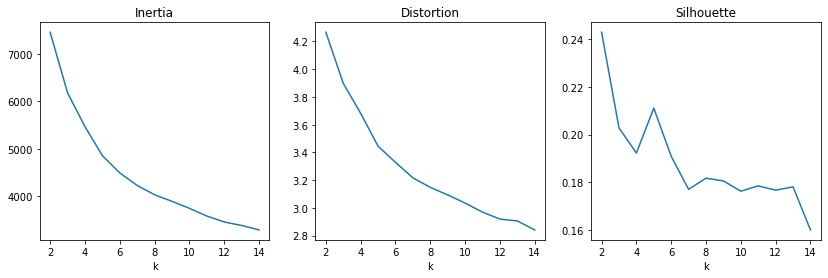

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))

for i, metric in enumerate(metrics.columns):
    
    y = metrics[metric].values
    x = metrics.index
    axes[i].plot(x,y)
    axes[i].set_title(metric)
    axes[i].set_xlabel('k')
plt.show()

The inertia and distortin method do not suggest a clear k, but it might be between 5 and 8. The silhouette method would suggest a k=2

## Optional

In the original publication, they choose an optimal number of clusters equal to 8 (due to the similar scores achieved by k between 6 and 8 and the fact that the original classes of ligands was 8). Build a k-Means model with k=8 and fit it with 1000 different random seeds. Then, count how many times each ligand is grouped in the same cluster of the positive (Pd(I)-inducing) ligands.

In [51]:
#Initialize
best_model = KMeansModel(X=X, k=8, rs=1)

# Run the model
best_model.run()

#Run the algorithm  
stats = best_model.stats(ref_ids=pos_refs, k=8)

100%|██████████| 1000/1000 [01:16<00:00, 13.05it/s]


This way we obtain a statistics dataframe that can be used to filter the ligands based on the Score (normalized number of times that a given ligand is clustered with the reference ligands).

In [52]:
#example, take only the ligands whose score is higher than 0.5 (select indices)
filtered = stats[stats['Score'] > 0.75].index

Visualize the indices of the clustered ligands and verify that number 21 (non-inducing ligand) is not included in this group. This array of indices can be used to select and filter the original data.

In [54]:
filtered

Int64Index([ 15,  16,  19,  26,  33,  40,  41,  44,  54,  55,  58,  60,  62,
             63,  64,  65,  66,  67,  68,  70,  71,  72,  73,  74,  76,  78,
             79,  83,  86,  87,  88,  89,  90,  91,  93,  96,  97,  99, 102,
            103, 105, 109, 113, 115, 119, 120, 122, 126, 127, 128, 129, 130,
            131, 132, 133, 134, 135, 139, 140, 141, 152, 161, 164, 165, 167,
            170, 171, 173, 176, 178, 179, 180, 183, 186, 270, 292, 297, 298,
            302, 303, 309, 310, 315, 316, 323, 325, 341, 342],
           dtype='int64')

Check also that this group of ligands contains mixed ligand types.

In [28]:
ligands['Type'][filtered].value_counts()

R           44
Ar          34
NR2/NAr2     7
PABC         2
CH2=CH2      1
Name: Type, dtype: int64

Great! We have got rid of the nasty non-inducing ligand. Besides, our selected cluster now contains different types of ligands. This is a good first step. 

# 3. DFT-specific descriptors

The first clustering reduced the candidate ligands space to ~25% of the original size, keeping 89 ligands from the list of 348. A subsequent k-means clustering using the general descriptors in order to refine this first filtering failed. Therefore, the descriptors needed to be tuned for this specific problem. DFT-specific descriptors related to the Pd(I) iodine bridge were calculated and included in the dataset (a total of 42 new descriptors).

We will not calculate all the DFT descriptors, but just load the dataset containing the refined ligands. This dataframe only contains 66 ligands as the calculations were only done for ligands containing P-C bonds.

In [30]:
#Load and visualize the dataframe containing DFT-specific descriptors (the Dimer_LKB_P.csv file)
dimers = pd.read_csv('../data/Dimer_LKB_P.csv', sep=';')

dimers.head()


,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(Pd),BE(Pd),Pd-Cl trans,P-Pd,...,G_NBO_Pd,G_NBO_P,G_LENGTH_Pd_P,G_LENGTH_Pd_Pd,G_TORSION_Pd_I_I_Pd,G_ORDER_Pd_Pd,PC1',PC2',PC3',PC4'
0,15,R,-0.17500,0.02350,37.82,247.52,-1.257,30.03,2.379,2.337,...,-0.379685,1.297005,2.312152,3.226557,103.059842,0.1171,-0.986788,0.414056,0.017615,-0.632639
1,16,R,-0.17267,0.02754,23.38,250.80,-1.200,23.90,2.382,2.418,...,-0.278010,1.232615,2.413734,4.305073,174.451579,0.0264,1.198717,1.162347,0.901051,-0.055612
2,19,R,-0.18340,0.01900,31.31,243.63,-1.282,28.25,2.377,2.308,...,-0.340260,1.205245,2.314010,3.620629,124.149654,0.0713,-0.146169,-0.318877,0.877642,-0.227544
3,36,R,-0.17840,0.02300,19.69,245.86,-1.275,34.79,2.379,2.321,...,-0.365385,1.280040,2.317294,3.187955,101.341176,0.1254,-1.135555,0.275201,0.181931,-0.516078
4,37,R,-0.17790,0.02220,18.53,246.58,-1.253,35.72,2.380,2.334,...,-0.387150,1.284050,2.346424,3.102411,95.391197,0.1369,-0.904739,0.447820,0.106396,-0.301205


# 4. Final clustering: unraveling new ligands

Once the new descriptors were calculated, we can try a second k-Means clustering to see if we can reduce even more our candidate space. Repeat the same clusterig process to select the optimum k.

In [60]:
# Columns in the data set to exclude 
drop = ["Type", "PC1", "PC2", "PC3", "PC4", "PC1'", "PC2'", "PC3'", "PC4'"]

#Preprocess data
X_dimers = dimers.drop(columns=drop)
X_dimers = min_max_scale(X_dimers)

# Initialize the model
model = KMeansModel(X=X_dimers, k=6, rs=8)

# Run the optimization and get metrics, clusters and per sample silhouette scores for each value of k
metrics, clusters, sil_samples = model.opt(ks=range(2, 15))

100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


Plot the metrics

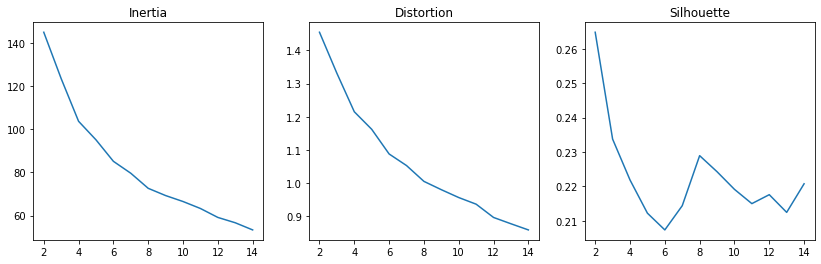

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))

for i, metric in enumerate(metrics.columns):
    
    y = metrics[metric].values
    x = metrics.index
    axes[i].plot(x,y)
    axes[i].set_title(metric)

plt.show()

In this case, we see again that the metrics do not seem very informative, but the k might be between 4 and 8

## Optional

In the original publication, they choose an optimal number of clusters equal to 6. Build a k-Means model with k=6 and fit it with 1000 different random seeds. Then, count how many times each ligand is grouped in the same cluster of the positive ligands.

In [68]:
#Initialize
best_model = KMeansModel(X=X_dimers, k=6, rs=1)

#adjust the references of the positive ligands in the new dataframe
refs = [1, 8, 18, 36]

# Run the model
best_model.run()

#Run the algorithm  
stats_dimers = best_model.stats(ref_ids=refs, k=6)

100%|██████████| 1000/1000 [00:26<00:00, 37.34it/s]


Now, select the ligands that are grouped in the same clusters than our reference ligands more than 50% of the time.

In [73]:
#example, take only the ligands whose score is higher than 0.5
dimers[stats_dimers['Score'] > 0.5]

,No.,Type,E(HOMO),E(LUMO),He8_steric,PA,Q(Pd),BE(Pd),Pd-Cl trans,P-Pd,...,G_NBO_Pd,G_NBO_P,G_LENGTH_Pd_P,G_LENGTH_Pd_Pd,G_TORSION_Pd_I_I_Pd,G_ORDER_Pd_Pd,PC1',PC2',PC3',PC4'
0,15,R,-0.17500,0.02350,37.82,247.52,-1.257,30.03,2.379,2.337,...,-0.379685,1.297005,2.312152,3.226557,103.059842,0.1171,-0.986788,0.414056,0.017615,-0.632639
1,16,R,-0.17267,0.02754,23.38,250.80,-1.200,23.90,2.382,2.418,...,-0.278010,1.232615,2.413734,4.305073,174.451579,0.0264,1.198717,1.162347,0.901051,-0.055612
3,36,R,-0.17840,0.02300,19.69,245.86,-1.275,34.79,2.379,2.321,...,-0.365385,1.280040,2.317294,3.187955,101.341176,0.1254,-1.135555,0.275201,0.181931,-0.516078
4,37,R,-0.17790,0.02220,18.53,246.58,-1.253,35.72,2.380,2.334,...,-0.387150,1.284050,2.346424,3.102411,95.391197,0.1369,-0.904739,0.447820,0.106396,-0.301205
5,38,R,-0.17610,0.02290,25.93,246.89,-1.267,30.17,2.378,2.334,...,-0.378850,1.286440,2.316204,3.239473,103.321764,0.1152,-1.040206,0.316550,0.127169,-0.580331
6,39,R,-0.17520,0.02270,16.68,248.60,-1.285,31.24,2.379,2.323,...,-0.362885,1.295805,2.300574,3.230060,103.544695,0.1215,-1.275353,0.442776,0.071003,-0.637937
7,40,R,-0.17880,0.02253,15.00,245.67,-1.266,35.99,2.379,2.332,...,-0.348165,1.254485,2.325474,4.081617,167.394226,0.0300,-0.363451,0.181895,0.817960,-0.657653
8,41,R,-0.17250,0.02830,20.96,250.18,-1.200,21.83,2.379,2.430,...,-0.319535,1.279885,2.358549,4.182134,175.186199,0.0276,0.402554,0.744353,0.697837,-0.610528
9,42,R,-0.17660,0.02200,30.21,248.25,-1.241,29.09,2.379,2.356,...,-0.309540,1.252010,2.353172,3.563624,114.587419,0.0813,0.657121,1.031865,0.320937,-0.002373
10,43,R,-0.17270,0.02600,22.86,250.62,-1.249,33.95,2.379,2.364,...,-0.319980,1.299765,2.352620,3.525353,114.352055,0.0855,-0.330530,0.977002,0.011642,-0.507154


# 5. Experimental validation

The second clustering grouped 21 new ligands together with the 4 already known Pd(I) dimer-inducer ligands. These predictions were tested experimentally, and these were the results:

<div align="left">
<img src="../img/exp_validation.png" width="400"/>
</div>

8 new dimers were discovered! Quite an impressive result given the low amount of previous data and the poor understanding of ligand-speciation relationship. You can check the structures of the proposed ligands in the SI of the original paper, and realize how different these molecules are. Probably, a human researcher would have discarded them, but ML was able to point out the similarities and provide meaningful counterintuitive experimental suggestions.

# Conclusion

In this notebook, you have seen how a simple algorithm like k-means can be very powerful if applied wisely. Researchers at the interface of ML and Chemistry can combine both domains to obtain impressive results. We hope this example motivates you to keep learning more!

Finally, [here](https://github.com/J-Hueffel/PdDimer) is the repo from the original publication, in case you want to check the code. We would also like to acknowledge the [Schoenebeck](https://www.schoenebeck.oc.rwth-aachen.de/) group for this fantastic work.